<a href="https://colab.research.google.com/github/kandgesid/Data-Science-and-ML-projects/blob/master/facenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

referred from [facenet](https://github.com/Skuldur/facenet-face-recognition) for data and pretrained model weigths

Cloned repo for weights and inception_blocks_v2.py file

In [ ]:
!git clone https://github.com/Skuldur/facenet-face-recognition.git

Cloning into 'facenet-face-recognition'...
remote: Enumerating objects: 276, done.
remote: Total 276 (delta 0), reused 0 (delta 0), pack-reused 276
Receiving objects: 100% (276/276), 29.04 MiB | 8.82 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [ ]:
%cd '/content/facenet-face-recognition'

/content/facenet-face-recognition


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *
import sys

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=sys.maxsize)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

In [ ]:
print("Total Params:", FRmodel.count_params())

Total Params: 3743280


**TRIPLET LOSS FUNCTION**

In [ ]:

def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    ### START CODE HERE ### (≈ 4 lines)
    # Step 1: Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum((anchor - positive) ** 2, axis=-1)
    # Step 2: Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum((anchor - negative) ** 2, axis=-1)
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = pos_dist - neg_dist + alpha
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))
    ### END CODE HERE ###
    
    return loss

In [ ]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

In [ ]:
def prepare_database():
    database = {}

    # load all the images of individuals to recognize into the database
    for file in glob.glob("images/*"):
        identity = os.path.splitext(os.path.basename(file))[0]
        database[identity] = img_path_to_encoding(file, FRmodel)
    return database

In [ ]:
import glob
database = prepare_database()

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


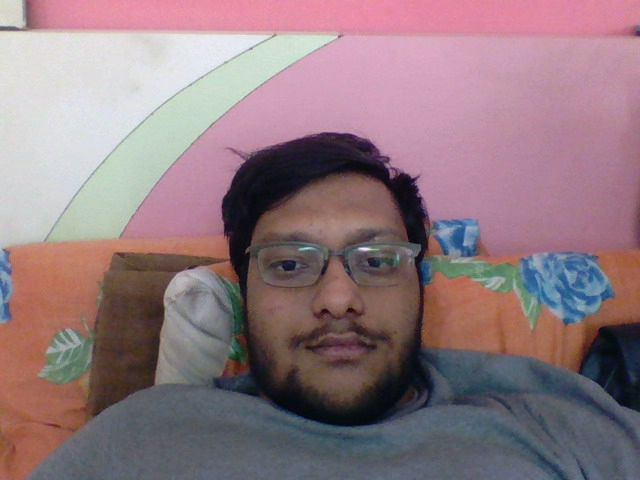

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:

def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
    image_path -- path to an image
    identity -- string, name of the person you'd like to verify the identity. Has to be an employee who works in the office.
    database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
    model -- your Inception model instance in Keras
    
    Returns:
    dist -- distance between the image_path and the image of "identity" in the database.
    door_open -- True, if the door should open. False otherwise.
    """
    
    ### START CODE HERE ###
    
    # Step 1: Compute the encoding for the image. Use img_to_encoding() see example above. (≈ 1 line)
    encoding = img_path_to_encoding(image_path, model)
    
    # Step 2: Compute distance with identity's image (≈ 1 line)
    dist = np.linalg.norm(encoding-database[identity])
    
    # Step 3: Open the door if dist < 0.7, else don't open (≈ 3 lines)
    if dist < 0.7:
        print("It's " + str(identity) + ", welcome in!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
        
    ### END CODE HERE ###
        
    return dist, door_open

In [ ]:
identity = os.path.splitext(os.path.basename("/content/facenet-face-recognition/camera_0.jpg"))[0]
identity

'camera_0'

In [ ]:
verify("camera_0.jpg", "dan", database, FRmodel)

It's not dan, please go away


(0.76801896, False)

FACE RECOGNITION

In [ ]:

def who_is_it(image_path, database, model):
    """
    Implements face recognition for the office by finding who is the person on the image_path image.
    
    Arguments:
    image_path -- path to an image
    database -- database containing image encodings along with the name of the person on the image
    model -- your Inception model instance in Keras
    
    Returns:
    min_dist -- the minimum distance between image_path encoding and the encodings from the database
    identity -- string, the name prediction for the person on image_path
    """
    
    ### START CODE HERE ### 
    
    ## Step 1: Compute the target "encoding" for the image. Use img_to_encoding() see example above. ## (≈ 1 line)
    encoding = img_path_to_encoding(image_path, model)
    
    ## Step 2: Find the closest encoding ##
    
    # Initialize "min_dist" to a large value, say 100 (≈1 line)
    min_dist = 100
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current db_enc from the database. (≈ 1 line)
        dist = np.linalg.norm(encoding-db_enc)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. (≈ 3 lines)
        if dist < min_dist:
            min_dist = dist
            identity = name

    ### END CODE HERE ###
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

In [ ]:
who_is_it("camera_1.jpg", database, FRmodel)

it's siddhant, the distance is 0.63802683


(0.63802683, 'siddhant')